In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

Load Dataset from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/UTKFace.zip'

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/52_0_3_20170113184200775.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170113190623929.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170117190840617.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119160357804.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119181010188.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200211340.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200241996.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200259595.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200407188.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119204331863.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119204337838.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205638160.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205639336.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205641007.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205647136.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_201701

In [ ]:
BASE_DIR = '/content/UTKFace'
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# converting the above to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()


,image,age,gender
0,/content/UTKFace/58_0_0_20170111204009616.jpg....,58,0
1,/content/UTKFace/58_1_1_20170117194028702.jpg....,58,1
2,/content/UTKFace/1_1_0_20170109190936410.jpg.c...,1,1
3,/content/UTKFace/89_1_0_20170120230445570.jpg....,89,1
4,/content/UTKFace/31_0_2_20161219192759515.jpg....,31,0


In [ ]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image paths: 23708


In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

Vizualization

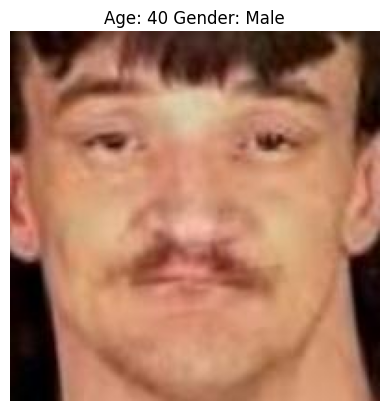

In [ ]:
from PIL import Image
import random

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image'][rand_index])
plt.title(f'Age: {age} Gender: {gender_dict[gender]}')
plt.axis('off')
plt.imshow(IMG)

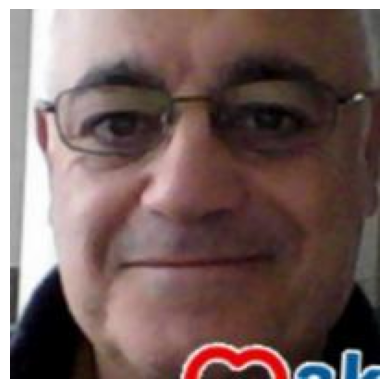

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

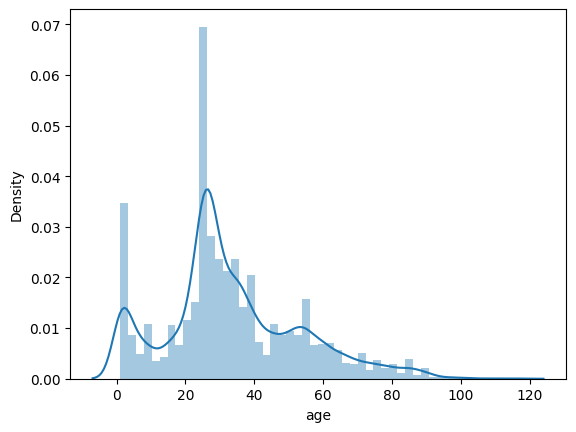

In [ ]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

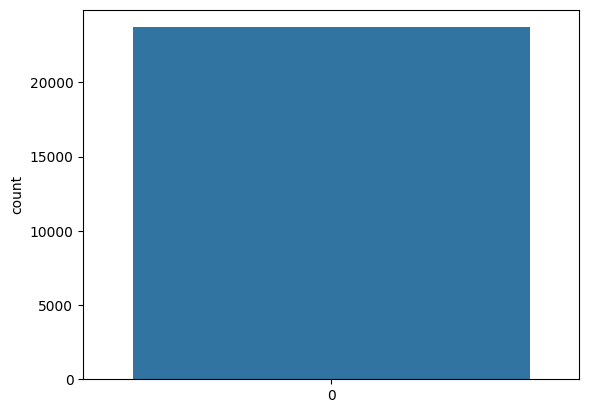

In [ ]:
sns.countplot(df['gender'])

<Axes: ylabel='count'>

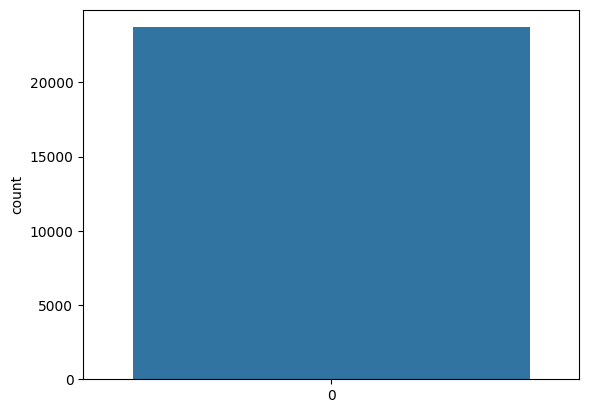

In [ ]:
sns.countplot(df['age'])

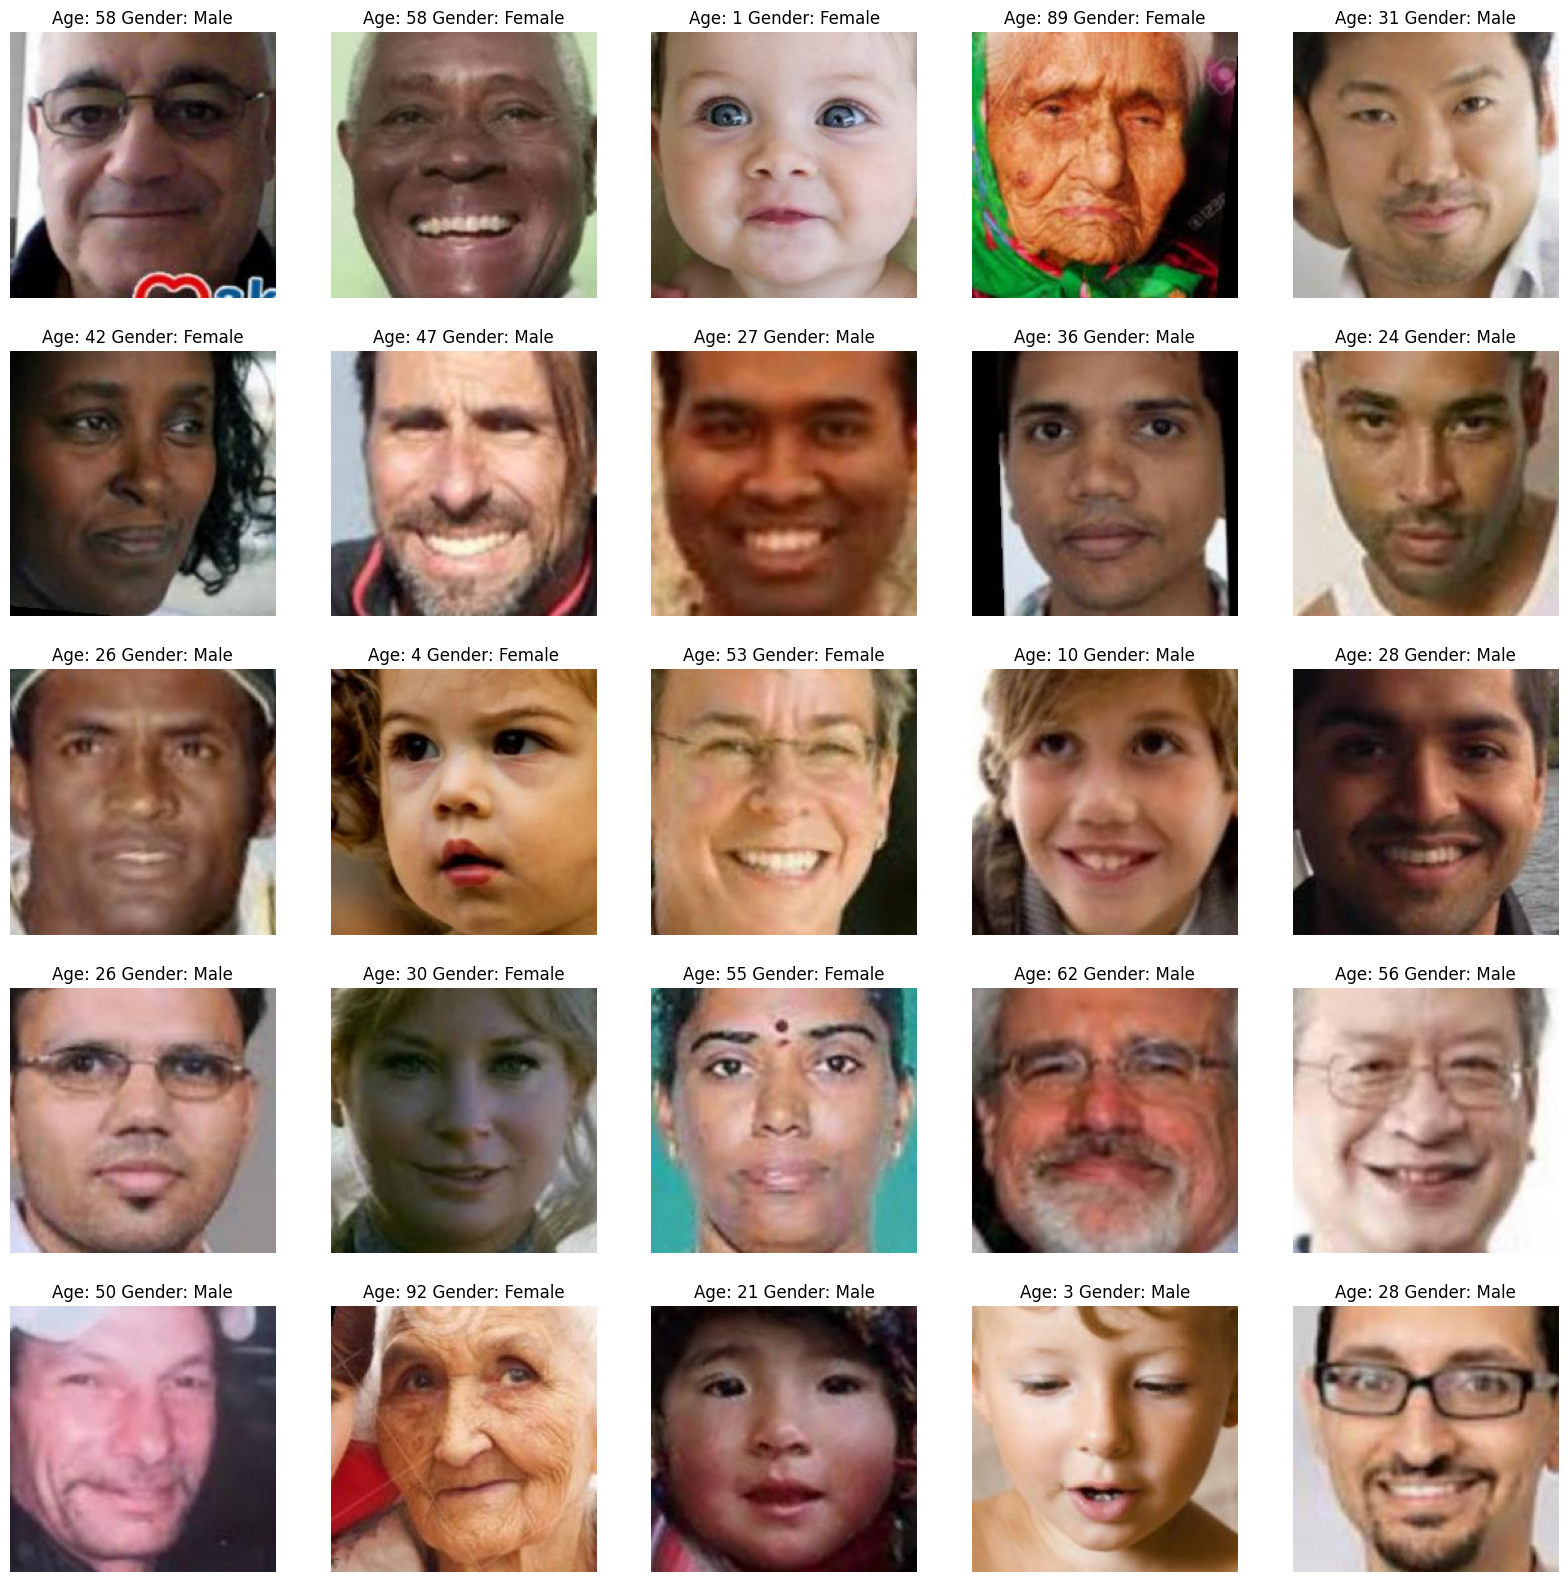

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

How to extract feature

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))
# convolutional layers
con_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (con_1)
con_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (con_2)
con_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (con_3)
con_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (con_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

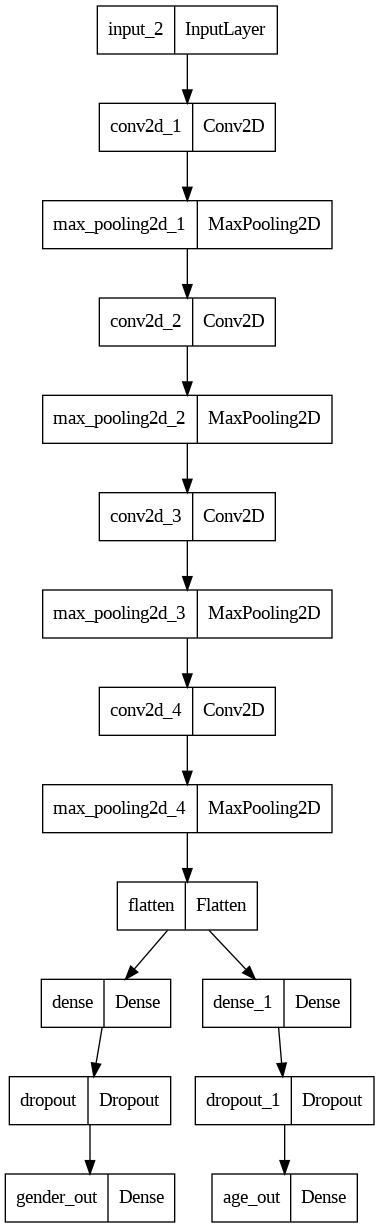

In [ ]:
#ploting the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
593/593 [==============================] - 788s 1s/step - loss: 9.2047 - gender_out_loss: 0.3621 - age_out_loss: 8.8426 - gender_out_accuracy: 0.8317 - age_out_accuracy: 0.0092 - val_loss: 8.3878 - val_gender_out_loss: 0.3658 - val_age_out_loss: 8.0220 - val_gender_out_accuracy: 0.8338 - val_age_out_accuracy: 0.0086
Epoch 2/5
593/593 [==============================] - 763s 1s/step - loss: 8.7533 - gender_out_loss: 0.3484 - age_out_loss: 8.4049 - gender_out_accuracy: 0.8402 - age_out_accuracy: 0.0086 - val_loss: 8.3601 - val_gender_out_loss: 0.3497 - val_age_out_loss: 8.0105 - val_gender_out_accuracy: 0.8450 - val_age_out_accuracy: 0.0095
Epoch 3/5
593/593 [==============================] - 765s 1s/step - loss: 8.4901 - gender_out_loss: 0.3387 - age_out_loss: 8.1514 - gender_out_accuracy: 0.8465 - age_out_accuracy: 0.0075 - val_loss: 8.6425 - val_gender_out_loss: 0.3474 - val_age_out_loss: 8.2950 - val_gender_out_accuracy: 0.8418 - val_age_out_accuracy: 0.0101
Epoch 4/5
593/59

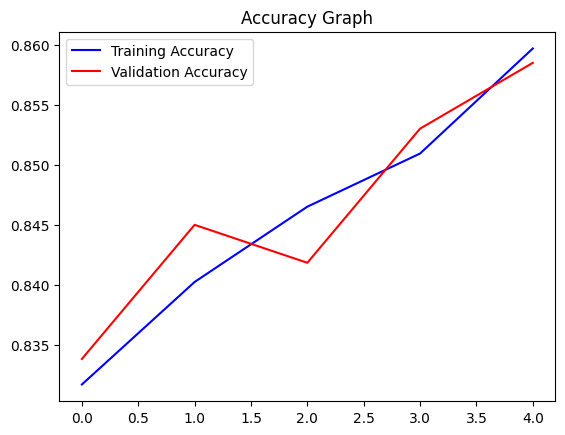

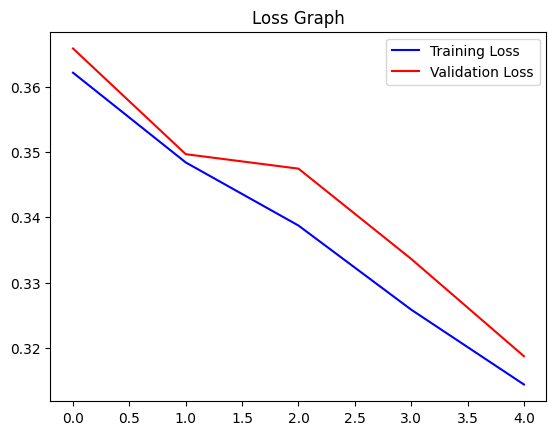

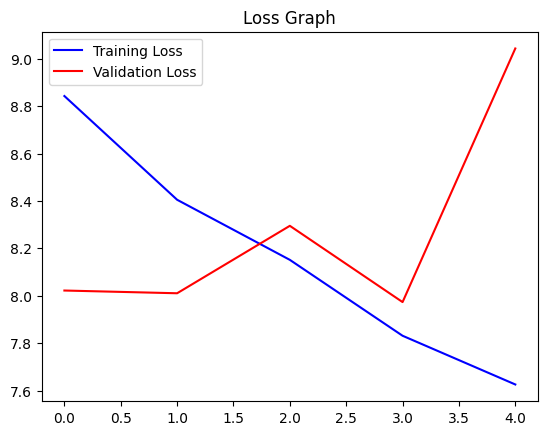

In [ ]:
# plot results for gender and age
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Test data

Original Gender: Female Original Age: 23
1/1 [==============================] - 0s 174ms/step
Predicted Gender: Female Predicted Age: 19


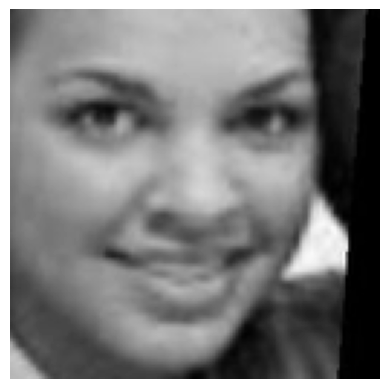

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 29
1/1 [==============================] - 0s 31ms/step
Predicted Gender: Male Predicted Age: 23


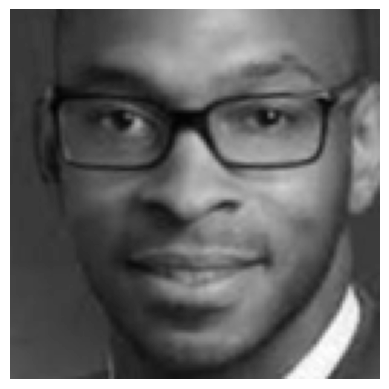

In [ ]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');